In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import datetime as dt
import warnings
import time
from matplotlib import pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored, as_concordance_index_ipcw_scorer, as_cumulative_dynamic_auc_scorer, as_integrated_brier_score_scorer

from sksurv.ensemble import RandomSurvivalForest, ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, accuracy_score, confusion_matrix

import eli5
from eli5.sklearn import PermutationImportance


In [56]:
#load data
pd.set_option('display.max_columns', None)
df = pd.read_csv('imputed_revent.csv')
df = df.drop(axis=1, columns=['Unnamed: 0','last_careunit'])
df=df.reset_index()

## 1: Post-pre-processing

#### 1.1: Variable grouping

In [74]:
for col in ['ext_time1','int_time2','dischtime']:
    df[col] = pd.to_datetime(df[col])

# get time to reintubation
def get_reventTime(ext_time1=None, int_time2=None, dischtime=None):
    time_to_reint = 0
    if int_time2 == np.NaN or pd.isna(int_time2):
        time_to_reint = 10000000
        return time_to_reint
    else:
        time_to_reint = int_time2 - ext_time1
        return time_to_reint.total_seconds()/3600

time_to_revent = []
for i in list(range(len(df))):
    y = get_reventTime(ext_time1=df['ext_time1'][i],int_time2=df['int_time2'][i],dischtime=df['dischtime'][i])
    time_to_revent.append(y)

df['time_to_revent'] = time_to_revent


In [75]:
# variables for analysis
categorical = ['ethnicity', 
              'marital_status',
              'language',
              'admission_location',
              'gender',
              'insurance',
              'first_careunit',
              'admission_type']
proceduretype=['aortic','mit','tricuspid','pulmonary','cabg']
ptParams = ['weight', 'height', 'bmi','duration1']
boolFields = ['reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids', 'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia', 
              'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia', 'hospital_expire_flag', 'diab_un', 'diab_cc','infection_vent']
ptinfo = ['hadm_id', 'subject_id']
ptTimes = ['int_time1','ext_time1','int_time2','ext_time2','admittime', 'dischtime', 'deathtime','intime', 'outtime', 'ext_time', 'icustay_seq']
tsColumns_last = [i for i in df.columns if '_last' in i]
tsColumns_first = [i for i in df.columns if '_first' in i]
tsColumns_notFirst = [i for i in df.columns if '_max' in i or '_min' in i or '_mean' in i or '_last' in i]

inputs = [*categorical , *proceduretype , *tsColumns_last, *ptParams , *[i for i in boolFields if i != 'reintubation']]
inputs_all = [*categorical , *proceduretype , *tsColumns_first , *tsColumns_notFirst, *ptParams , *[i for i in boolFields if i != 'reintubation']]
outcomes = ['reintubation','hospital_expire_flag','los','duration2','icu_stay_duration','time_to_revent']

print([i for i in df.columns if i not in categorical + proceduretype + tsColumns_first + tsColumns_notFirst + ptParams + boolFields + ptinfo + ptTimes + outcomes])
print([i for i in df.columns if i not in inputs + outcomes + ptTimes + tsColumns_first])

['index', 'censor']
['index', 'temp_mean', 'temp_max', 'temp_min', 'bg_temp_mean', 'bg_temp_max', 'bg_temp_min', 'hr_mean', 'hr_max', 'hr_min', 'spo2_mean', 'spo2_max', 'spo2_min', 'rr_mean', 'rr_max', 'rr_min', 'sbp_mean', 'sbp_max', 'sbp_min', 'dbp_mean', 'dbp_max', 'dbp_min', 'meanbp_mean', 'meanbp_max', 'meanbp_min', 'cardiac_index_mean', 'cardiac_index_max', 'cardiac_index_min', 'pt_mean', 'pt_max', 'pt_min', 'ptt_mean', 'ptt_max', 'ptt_min', 'inr_mean', 'inr_max', 'inr_min', 'inr_1_mean', 'inr_1_max', 'inr_1_min', 'fibrinogen_mean', 'fibrinogen_max', 'fibrinogen_min', 'hb_mean', 'hb_max', 'hb_min', 'hematocrit_mean', 'hematocrit_max', 'hematocrit_min', 'wcc_mean', 'wcc_max', 'wcc_min', 'lymphocytes_mean', 'lymphocytes_max', 'lymphocytes_min', 'neutrophils_mean', 'neutrophils_max', 'neutrophils_min', 'alp_mean', 'alp_max', 'alp_min', 'ast_mean', 'ast_max', 'ast_min', 'alt_mean', 'alt_max', 'alt_min', 'bilirubin_total_mean', 'bilirubin_total_max', 'bilirubin_total_min', 'chloride_m

In [76]:
# change categorical to category type
for col in categorical:
    df[col] = df[col].astype('category')

In [77]:
# change dt to dt type
for col in [i for i in ptTimes if i != 'icustay_seq']:
    df[col] = pd.to_datetime(df[col])

In [79]:
# create censor column for death before extubation
censor = []
for i in range(len(df)):
    int_time2=df['int_time2'][i]
    if int_time2 == np.NaN or pd.isna(int_time2):
        #censor.append(False)
        censor.append(True)
    elif pd.isnull(df['deathtime'][i]) or df['deathtime'][i] >= df['ext_time1'][i]:
        censor.append(True)
    else:
        censor.append(False)
censored = []
for i in range(len(censor)):
    if censor[i] == False:
        censored.append(i)
print('Number censored: '+str(len(censored)))
print(censored)

df['censor'] = censor

Number censored: 0
[]


#### 1.2: !!X, Xt, y!!

In [80]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] = df['time_to_revent']
y

array([( True, 10000000.), ( True, 10000000.), ( True, 10000000.), ...,
       ( True, 10000000.), ( True, 10000000.), ( True, 10000000.)],
      dtype=[('Censor', '?'), ('Survival', '<f8')])

#### 1.3: Plotting y

Text(0.5, 0, 'time $t$')

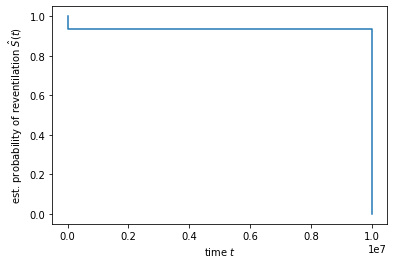

In [81]:
# view the data
time, survival_prob = kaplan_meier_estimator(y["Censor"], y["Survival"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of reventilation $\hat{S}(t)$")
plt.xlabel("time $t$")

(array([42., 32., 38., 43., 30., 74., 58., 48., 23., 26., 27., 18., 15.,
        14., 11.,  5., 10.,  4.,  4., 12., 10.]),
 array([ 0,  3,  6,  9, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
        75, 80, 85, 90, 95]),
 <BarContainer object of 21 artists>)

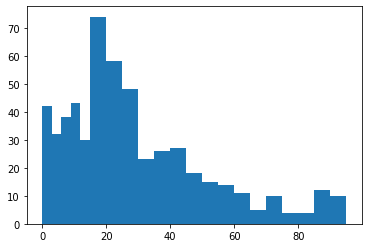

In [82]:
plt.hist(y["Survival"],bins=[0,3,6,9,12,15,20,25,30,*list(range(35,100,5))],range=(0,100))

## 2: DL Survival Analysis

### 2.1: Cox models

#### 2.1.1: CoxPH

In [83]:
Xt = OneHotEncoder().fit_transform(X)
cph = CoxPHSurvivalAnalysis()
cph.fit(Xt, y)

# get c-index of trained estimator
pred = cph.predict(Xt)
result = concordance_index_censored(y['Censor'], y["Survival"], pred)
print('C-index of Cox model: '+str(result[0]))

C:\Users\marcel\anaconda3\envs\tridentenv\lib\site-packages\sksurv\linear_model\coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=6.16195e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


C-index of Cox model: 0.8110287338133269


In [84]:
alphas = 10. ** np.linspace(-4,4,10)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

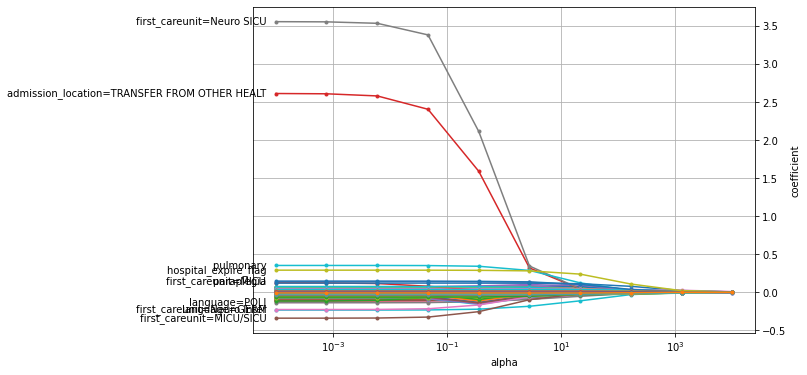

In [85]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
plot_coefficients(coefficients, n_highlight=10)

#### 2.1.2: Cox Elastic Net

In [ ]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(Xt, y)

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order[-20:]].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### 2.2: Random Survival Forest

In [86]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['time_to_revent']
y

array([( True, 10000000.), ( True, 10000000.), ( True, 10000000.), ...,
       ( True, 10000000.), ( True, 10000000.), ( True, 10000000.)],
      dtype=[('Censor', '?'), ('Survival', '<f8')])

In [87]:
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.20, random_state=random_state)

In [89]:
rsf = RandomSurvivalForest(n_estimators=100,
                            min_samples_split=5,
                            max_depth=10,
                            min_samples_leaf=1,
                            max_features="auto",
                            n_jobs=-1,
                            random_state=random_state)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.8223055713243046

In [91]:
lower, upper = np.percentile(y_train["Survival"], [10, 90])
rsf_times = np.arange(lower, upper + 1)

In [92]:
estimator = rsf
estimator.get_params().keys()

dict_keys(['bootstrap', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [94]:
rsf = RandomSurvivalForest()

cv = KFold(n_splits=3, shuffle=True, random_state=1)

cv_param_grid = {'estimator__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)],
              'estimator__max_features': ['auto', 'sqrt'],
              'estimator__max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
              'estimator__min_samples_split': [2, 5],
              'estimator__min_samples_leaf': [1, 2, 4],
              'estimator__bootstrap': [True, False]}
gcv = GridSearchCV(
    as_integrated_brier_score_scorer(rsf, times=rsf_times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=-1,
).fit(X_train, y_train)


C:\Users\marcel\anaconda3\envs\tridentenv\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [63]:
print ('Best parameters for RSF: {}'.format(rsf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rsf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rsf_tuned.predict(X_test))))

Best parameters for RSF: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Cross-validation F1 score: nan


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
rsf = RandomSurvivalForest(n_estimators=200,
                            min_samples_split=50,
                            min_samples_leaf=3,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)
parameters = {'n_estimators': [100, 200],
              'max_features': ['auto'],
              'max_depth': [50, 100],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,10],
              'bootstrap': [True, False]}
rsf_tuned = GridSearchCV(rsf, parameters, cv=5, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RF: {}'.format(rf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rf_tuned.predict(x_test))))

In [ ]:
perm = PermutationImportance(rsf, n_iter=3, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

### 2.3: GBM Survival

In [23]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['time_to_revent']
y

# get X_train, X_test, y_train, y_test
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

In [24]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.788


In [ ]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(10, 31,5):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

## 3: Exploring language and ventilation duration 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

dfImputed_onehot = dfImputed.copy()
dfImputed1 = pd.get_dummies(dfImputed_onehot, columns = ['ethnicity', 'language'], prefix = ['eth', 'lang'])
onehot_cols = [i for i in list(dfImputed1.columns) if i not in ['ethnicity', 'marital_status', 'language', 'admission_location']]
dfImputed1['duration1'] = df['duration1']
dfImputed1 = dfImputed1.dropna(axis=0, how='any')

In [ ]:
dfImputed1

In [ ]:
from matplotlib import pyplot
from scipy.stats import kstest, norm, pearsonr, ttest_ind

x = dfImputed1['lang_ENGL']
y = df['duration1'].dropna(axis=0,how='any')

#testing for normalcy
mu, std = norm.fit(x)
n = norm(loc=mu, scale=std)
normalcy_p = kstest(x, n.cdf)[1]
print('p-val: '+ str(normalcy_p))

pyplot.scatter(x,y)
covariance = np.cov(x,y)
print('Covariance matrix: ')
print(covariance)

#find pearson R
corr, _ = pearsonr(x,y)
print('Pearsons R: %.3f' %corr)

In [ ]:
import statsmodels.api as sm

univariable = pd.DataFrame(index = ['eth_white','lang_ENGL'], columns = ['OR (95% CI)','p-value'])

p_value = []
OR = []
time = []
for column in ['lang_ENGL']:
    for int_timelimit in range(0,48,1):
        X = dfImputed1[column].values
        X = sm.add_constant(X)
        y = pd.cut(df['duration1'].dropna(how='any'),bins=[-0.1,int_timelimit,4000],labels=[0,1])
        logit = sm.Logit(y, X)
        model = logit.fit(method='bfgs',disp = False)
        model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
        model_odds['p-value'] = model.pvalues
        model_odds[['2.5%','97.5%']]= np.exp(model.conf_int())
        model_odds.rename(index={'x1': column}, inplace = True)
        # insert it into the dataframe 'univariable'
        univariable.at[column,'OR (95% CI)'] = '{OR:.3f} ({lower:.3f} to {upper:.3f})'.format(OR = model_odds.at[column, 'OR'], 
                                                                                            lower = model_odds.at[column, '2.5%'], 
                                                                                            upper = model_odds.at[column, '97.5%'])
        univariable.at[column,'p-value'] = '{0:.3f}'.format(model_odds.at[column, 'p-value'])
        p_value.append(model_odds.at[column, 'p-value'])
        OR.append(model_odds.at[column, 'OR'])
        time.append(int_timelimit)

univariable

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(time, OR, label='OR',color='blue')
ax.set_xlabel("ventilation time")
ax.set_ylabel("OR")

ax2=ax.twinx()
ax2.plot(time, p_value, label='p-val',color='orange')
ax2.set_ylabel("p-val")


In [ ]:
x1 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==1].dropna(axis=0,how='any')
x2 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==0].dropna(axis=0,how='any')
plt.hist(x1,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60))
plt.hist(x2,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60),color='orange')
print('mean English: '+str(np.mean(x1)))
print('mean non-English: '+str(np.mean(x2)))
print('t_test p-val;: '+str(ttest_ind(x1, x2)[1]))